In [ ]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import openpyxl
from pathlib import Path
import numpy as np
from gensim.models import KeyedVectors

def cleaner(text):
    final_text = ''
    for word in text.split():
        if word.startswith('@'):
            continue
        elif word[-3:] in ['com', 'org']:
            continue
        elif word.startswith("RT"):
            continue
        elif word.startswith("#"):
            continue
        elif word.startswith('pic') or word.startswith('http') or word.startswith('www'):
            continue
        else:
            final_text += word+' '
    return final_text

df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/models/cleaned_2000.xlsx") 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df["tweet"] = df["text"].apply(cleaner)
df = df[["tweet","label"]]
sentences = df["tweet"].values
y = df["label"].values

training_texts, test_texts, training_labels, test_labels = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [ ]:
!pip install transformers
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import torch

In [ ]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-128k-uncased', do_lower_case=True)
sentences = df.tweet.values
max_len = 50

In [ ]:
input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True,
                        max_length = max_len,      
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

number_of_categories = 3

model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-128k-uncased",
    num_labels = number_of_categories, 
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

In [ ]:
epochs = 8

optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
import random
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime
import tensorflow as tf

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla T4


In [ ]:
torch.cuda.empty_cache()

Fine-Tuning the Model

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

seed_val = 8888

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels,
                             return_dict=False)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 8 ========
Batch    10  of     47.    Elapsed: 0:00:13.
Batch    20  of     47.    Elapsed: 0:00:26.
Batch    30  of     47.    Elapsed: 0:00:39.
Batch    40  of     47.    Elapsed: 0:00:53.
Average training loss: 1.05
Training epoch took: 0:01:02
======== Epoch 2 / 8 ========
Batch    10  of     47.    Elapsed: 0:00:13.
Batch    20  of     47.    Elapsed: 0:00:27.
Batch    30  of     47.    Elapsed: 0:00:40.
Batch    40  of     47.    Elapsed: 0:00:53.
Average training loss: 0.78
Training epoch took: 0:01:03
======== Epoch 3 / 8 ========
Batch    10  of     47.    Elapsed: 0:00:13.
Batch    20  of     47.    Elapsed: 0:00:27.
Batch    30  of     47.    Elapsed: 0:00:40.
Batch    40  of     47.    Elapsed: 0:00:54.
Average training loss: 0.52
Training epoch took: 0:01:03
======== Epoch 4 / 8 ========
Batch    10  of     47.    Elapsed: 0:00:13.
Batch    20  of     47.    Elapsed: 0:00:27.
Batch    30  of     47.    Elapsed: 0:00:40.
Batch    40  of     47.    Elapsed

Saving the Model

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/models/model_2000_32b_8e_weights.pt'
torch.save(model, path)

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/models/model_32b_8e_weights.pt'
model = torch.load(path)

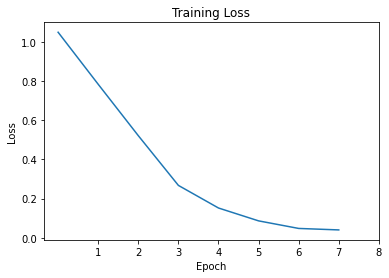

In [ ]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1,2,3,4,5,6,7,8])
plt.show()

In [ ]:
input_ids = []
attention_masks = []
max_len = 50

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

Prediction started on test data
Prediction completed


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

In [ ]:
f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')

print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))
report = report.rename(columns={'0':'negative',
                          '1':'neutral',
                          '2':'positive',
                          })

report

F-Score:  0.7456496265697682
Recall:  0.7410060580792289
Precision:  0.7530655871139099


,negative,neutral,positive,accuracy,macro avg,weighted avg
precision,0.760000,0.733068,0.766129,0.748,0.753066,0.748903
recall,0.664336,0.786325,0.772358,0.748,0.741006,0.748000
f1-score,0.708955,0.758763,0.769231,0.748,0.745650,0.747093
support,143.000000,234.000000,123.000000,0.748,500.000000,500.000000


  Testing with Windwoker Data
  

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/models/model_32b_8e_weights.pt'
model = torch.load(path)

In [ ]:
!pip install datasets
from datasets import load_dataset

dataset = load_dataset("winvoker/turkish-sentiment-analysis-dataset")

In [ ]:
tweets = []
for idx in range(0,len(dataset["train"])):
  line = dataset["train"][idx]
  if line["dataset"] == "tweet-pn":
    tweets.append(line)
for idx in range(0,len(dataset["test"])):
  line = dataset["test"][idx]
  if line["dataset"] == "tweet-pn":
    tweets.append(line)


In [ ]:
list_dict_tweets = []
num_test = len(dataset["test"])
for idx in range(0,num_test):
  line = dataset["test"][idx]
  if line["dataset"] == "tweet-pn" :
    list_dict_tweets.append(line)
num_train = len(dataset["train"])
for idx in range(0,num_train):
  line = dataset["train"][idx]
  if line["dataset"] == "tweet-pn" :
    list_dict_tweets.append(line)

list_dict_wiki = []
num_test = len(dataset["test"])
for idx in range(0,num_test):
  line = dataset["test"][idx]
  if line["dataset"] == "wiki" :
    list_dict_wiki.append(line)
num_train = len(dataset["train"])
for idx in range(0,num_train):
  line = dataset["train"][idx]
  if line["dataset"] == "wiki" :
    list_dict_wiki.append(line)



In [ ]:
import random
n=9000
list_dict_wiki = random.sample(list_dict_wiki, n)
list_dict = list_dict_tweets + list_dict_wiki
windwoker_df = pd.DataFrame(list_dict)
s = pd.Series(windwoker_df["label"])
windwoker_df["label"] = s.map({'Negative': 0, "Notr": 1,"Positive": 2})
test_texts = windwoker_df["text"].values
test_labels = windwoker_df["label"].values

In [ ]:
input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

Prediction started on test data
Prediction completed


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')

print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))
report = report.rename(columns={'0':'negative',
                          '1':'neutral',
                          '2':'positive',
                          })

report

F-Score:  0.5684871430880851
Recall:  0.6132070273572121
Precision:  0.6772099874994443


,negative,neutral,positive,accuracy,macro avg,weighted avg
precision,0.637882,0.648084,0.745665,0.65096,0.677210,0.675174
recall,0.761272,0.930000,0.148349,0.65096,0.613207,0.650960
f1-score,0.694136,0.763860,0.247465,0.65096,0.568487,0.589854
support,4968.000000,9000.000000,6087.000000,0.65096,20055.000000,20055.000000


Find the texts that fools the model Error Analysis



In [ ]:
length = len(prediction_scores)
index_list = []
for idx in range(0,length):
  if prediction_scores[idx] != test_labels[idx]:
    index_list.append(idx)

miss_predict_df = windwoker_df.iloc[index_list]
miss_predict_df

,text,label,dataset
6,Kesin öyle olmuştur. Çocukla kız el ele yolda ...,2,tweet-pn
11,ablacım reis halka üç yüz metre mesafeden sesl...,2,tweet-pn
13,Bir yazar ülkesine tarihine sosyolojisine nas...,2,tweet-pn
16,Öngörün gerçekleşti maalesef,2,tweet-pn
17,ananem ben küçükken sabah kalkınca hemen yüzün...,2,tweet-pn
...,...,...,...
20004,Eski çarşısı görülmeye değerdir .,1,wiki
20014,Mimarisi yoğun bir Osmanlı karakteri taşımakta...,1,wiki
20040,Aksi halde arabası elinden alınacaktır .,1,wiki
20048,Partizanlar ve partizan olduğu düşünülen kişil...,1,wiki


In [ ]:
pos = miss_predict_df[miss_predict_df["label"]==2]
len(pos)